# Averaged Artifact Substraction with EEG Data
## First step prepare Jupyter Notebook

In [1]:
import os
from FACET.Facet import Facet
from loguru import logger
import sys
os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))

eegDataSet_filepath = "NiazyFMRI.edf"
motiondata_moosmann_filepath = "headmotiondata.tsv"
export_bids_path = "./bids_dir"

#logging configuration
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("Facet.log", level="DEBUG")

#defining important parameters
window_size = 25
upsampling_factor = 10
relative_trigger_position = -0.01
relative_window_position = -0.5
moosmann_motion_threshold = 0.8
event_id_description_pairs={'trigger':1}
regex_trigger_annotation_filter = r'\b1\b' # Annotations with the description 'trigger' are considered as triggers
regex_trigger_event_filter = r'\b1\b' # Events with the value 1 are considered as triggers
unwanted_bad_channels = ['EKG', 'EMG', 'EOG', 'ECG'] # Channels with these names are considered as bad channels and not considered in the processing
evaluation_measures=["SNR", "RMS", "RMS2", "MEDIAN"]

f = Facet()


## Second Step import EEG Data

2024-03-07 12:45:42.455 | INFO     | FACET.Facet:import_EEG:18 - Importing EEG from NiazyFMRI.edf
2024-03-07 12:45:42.608 | INFO     | FACET.Facet:find_triggers:28 - finding triggers
2024-03-07 12:45:42.620 | INFO     | FACET.Facet:find_triggers:31 - Found 840


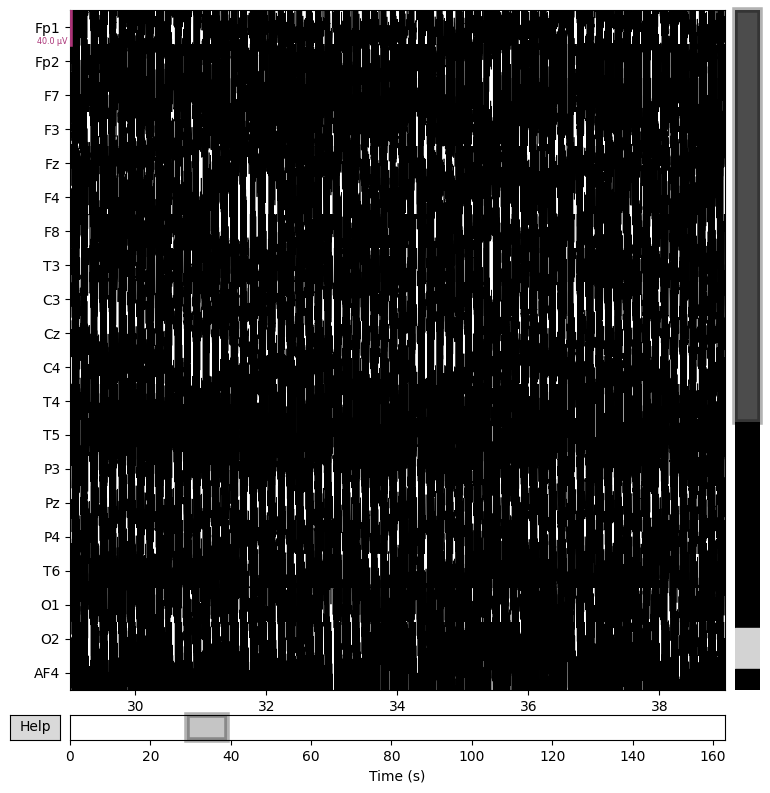

In [2]:
f.import_EEG(eegDataSet_filepath, rel_trig_pos=relative_trigger_position, upsampling_factor=upsampling_factor, bads=unwanted_bad_channels)
f.find_triggers(regex_trigger_event_filter)
eeg = f.get_EEG()
eeg = f.get_EEG()

f.plot_EEG(title="after import", start=29)

## Third Step Preprocessing

In [3]:
f.pre_processing()


2024-03-07 12:45:45.542 | INFO     | FACET.Frameworks.Correction:upsample:380 - Upsampling Data


## Fourth Step find triggers

In [4]:

f.find_triggers(regex_trigger_annotation_filter) # Using Niazys data
f.get_analytics().print_analytics()
eeg = f.get_EEG()


2024-03-07 12:46:10.344 | INFO     | FACET.Facet:find_triggers:28 - finding triggers
2024-03-07 12:46:10.627 | INFO     | FACET.Facet:find_triggers:31 - Found 840
2024-03-07 12:46:10.629 | INFO     | FACET.Frameworks.Analytics:print_analytics:405 - Analytics:
2024-03-07 12:46:10.630 | INFO     | FACET.Frameworks.Analytics:print_analytics:406 - Number of Triggers found: None
2024-03-07 12:46:10.631 | INFO     | FACET.Frameworks.Analytics:print_analytics:407 - Art Length: 3030
2024-03-07 12:46:10.632 | INFO     | FACET.Frameworks.Analytics:print_analytics:408 - Duration of Art in seconds: 0.14794921875
2024-03-07 12:46:10.632 | INFO     | FACET.Frameworks.Analytics:print_analytics:415 - Number of Channels: 33
2024-03-07 12:46:10.634 | INFO     | FACET.Frameworks.Analytics:print_analytics:416 - Channel Names: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'AF4', 'AF3', 'FC2', 'FC1', 'CP1', 'CP2', 'PO3', 'PO4', 'FC6', 'F

## Fourth step apply AAS

In [5]:
f.apply_AAS(window_size=window_size, rel_window_position=relative_window_position)

2024-03-07 12:46:10.644 | INFO     | FACET.Facet:apply_AAS:35 - Applying AAS with method numpy


## Fifth step Remove Artifacts

In [6]:
f.remove_artifacts( )
eeg = f.get_EEG()



## Sixth step Post-Processing

In [7]:
f.post_processing()

2024-03-07 12:46:21.584 | INFO     | FACET.Frameworks.Correction:downsample:369 - Downsampling Data


## Seventh display the processed eeg data

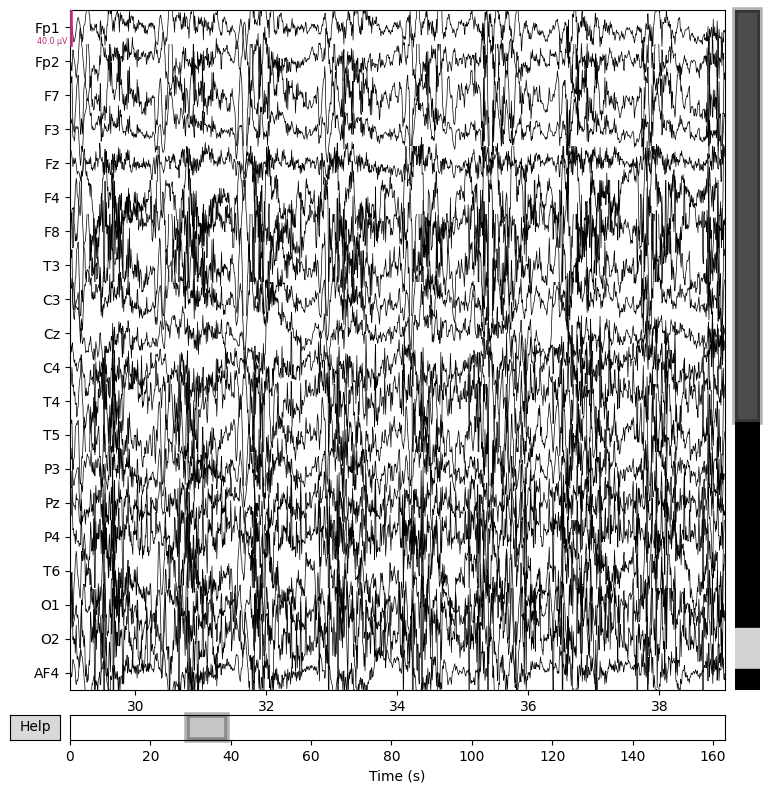

In [8]:
f.plot_EEG(title="after lowpass", start=29)

## Eighth Evaluate Results

2024-03-07 12:46:33.899 | INFO     | FACET.Facet:find_triggers:28 - finding triggers
2024-03-07 12:46:33.914 | INFO     | FACET.Facet:find_triggers:31 - Found 840
2024-03-07 12:46:33.937 | INFO     | FACET.Frameworks.Evaluation:add_to_evaluate:31 - ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'AF4', 'AF3', 'FC2', 'FC1', 'CP1', 'CP2', 'PO3', 'PO4', 'FC6', 'FC5', 'CP5', 'EMG', 'ECG', 'Status']
2024-03-07 12:46:34.044 | INFO     | FACET.Facet:import_EEG:18 - Importing EEG from NiazyFMRI.edf
2024-03-07 12:46:34.499 | INFO     | FACET.Frameworks.Correction:upsample:380 - Upsampling Data
2024-03-07 12:46:59.609 | INFO     | FACET.Facet:find_triggers:28 - finding triggers
2024-03-07 12:46:59.917 | INFO     | FACET.Facet:find_triggers:31 - Found 840
2024-03-07 12:46:59.919 | INFO     | FACET.Facet:apply_Moosmann:42 - Applying Moosmann with headmotiondata.tsv
2024-03-07 12:47:02.732 | INFO     | FACET.Frameworks.Correction:

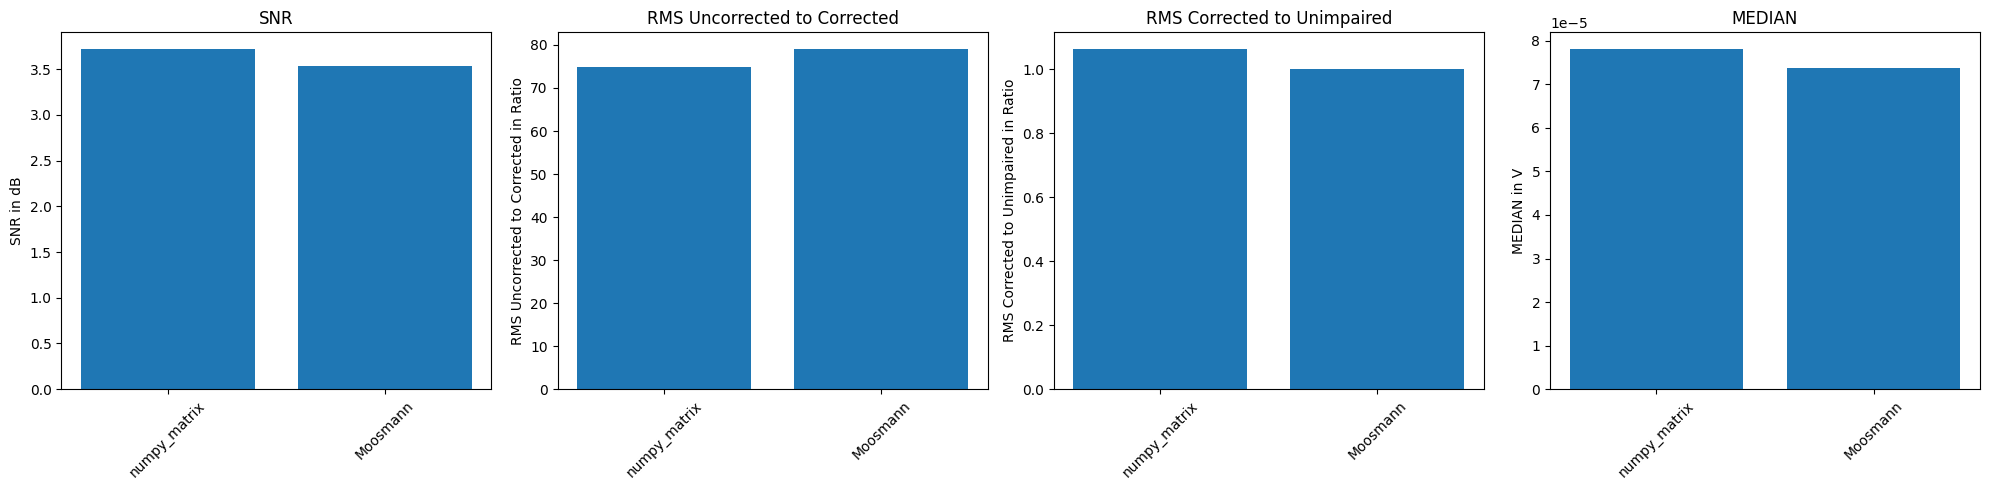

2024-03-07 12:47:16.486 | INFO     | __main__:<module>:15 - [{'Measure': 'SNR', 'Values': [3.7180776734343928, 3.530734081600355], 'Unit': 'dB'}, {'Measure': 'RMS Uncorrected to Corrected', 'Values': [74.84802544748831, 78.99062316595453], 'Unit': 'Ratio'}, {'Measure': 'RMS Corrected to Unimpaired', 'Values': [1.0617921937038952, 0.9999104406000303], 'Unit': 'Ratio'}, {'Measure': 'MEDIAN', 'Values': [7.804154699115283e-05, 7.364023563103644e-05], 'Unit': 'V'}]
2024-03-07 12:47:18.114 | INFO     | FACET.Frameworks.Analytics:export_as_bids:71 - Exporting Channels: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'AF4', 'AF3', 'FC2', 'FC1', 'CP1', 'CP2', 'PO3', 'PO4', 'FC6', 'FC5', 'CP5', 'EMG', 'ECG', 'Status']


In [9]:
f.find_triggers(regex_trigger_annotation_filter) # Using Niazys data
eeg_python = f.get_eeg()
f.add_to_evaluate(eeg_python, name="numpy_matrix") # Matrix will result in >1.0 RMS2 because of python mne inaccuracies

#apply moosmann
f.import_EEG(eegDataSet_filepath, rel_trig_pos=relative_trigger_position, bads=unwanted_bad_channels)
f.pre_processing()
f.find_triggers(regex_trigger_event_filter)
f.apply_Moosmann(file_path=motiondata_moosmann_filepath, threshold=moosmann_motion_threshold)
f.remove_artifacts()
f.post_processing()
f.find_triggers(regex_trigger_event_filter)
f.add_to_evaluate(f.get_eeg(), name="Moosmann")
results = f.evaluate(plot=True,measures=evaluation_measures)
logger.info(results)

f.export_as_bids(event_id=event_id_description_pairs, bids_path=export_bids_path)

